In [ ]:
pip install --force-reinstall git+https://github.com/meerakota/ucla_plha.git

# Validation of ground motion models

The purpose of this notebook is to validate our implementation of the four ground motion models. We have gathered images of relevant figures from the original references, and overlaid the corresponding data generated using the ucla_plha code. The original papers use lines of various color to represent ground motion vs. distance, and results from the ucla_plha code are shown as symbols using the same color scheme as the figures from the original papers. The figures often include plots of multiple intensity measures vs. distance. We have opted to include the entire figure even though we are only comparing with PGA. Furthermore, when PGA is not available, we use pseudo-spectral acceleration at 0.01s, which is adequately close to PGA for validation purposes. Alignment of the image and the data plot is performed by visual inspection and iteration, and is not perfect. For further validation, we have also plotted data points using the [pygmm](https://github.com/arkottke/pygmm) package using small symbols inside of the ucla_plha symbols. 

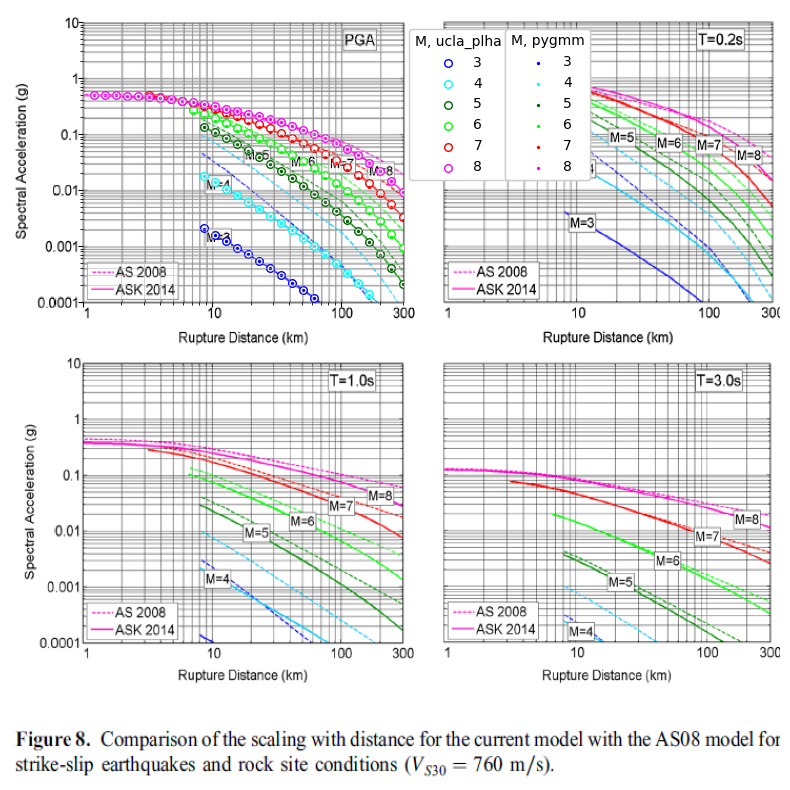

In [100]:
# Reproduce Fig. 8 from ASK model
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from ucla_plha.ground_motion_models import ask14
import pygmm

rrup_vec = np.logspace(0, np.log10(300), 30)
m_vec = np.asarray([3, 4, 5, 6, 7, 8])
rrup_lim = np.asarray([8, 8, 8, 6.5, 3.0, 1.0])
ztor_vec = np.asarray([8, 8, 8, 6.5, 3.0, 0.0])
colors = np.asarray(["blue", "cyan", "darkgreen", "lime", "red", "magenta"])
rrup = np.empty(len(m_vec) * len(rrup_vec), dtype=float)
m = np.empty(len(m_vec) * len(rrup_vec), dtype=float)
ztor = np.empty(len(m_vec) * len(rrup_vec), dtype=float)

vs30 = 760
dip = np.full(len(m), 90.0)
rx = np.full(len(m), 0.0)
rjb = np.full(len(m), 0.0)
rx1 = np.full(len(m), 0.0)
ry0 = np.full(len(m), 0.0)
fault_type = np.full(len(m), 3)
pga_pygmm = np.zeros(len(m))
measured_vs30 = True

I = 0
for i in range(len(m_vec)):
    for j in range(len(rrup_vec)):
        m[I] = m_vec[i]
        rrup[I] = rrup_vec[j]
        ztor[I] = ztor_vec[i]
        s = pygmm.model.Scenario(
            mag = m[I], 
            dist_jb = rjb[I], 
            dist_x = rx[I], 
            dist_rup = rrup[I], 
            dip = dip[I], 
            v_s30 = vs30, 
            mechanism = 'SS',
            on_hanging_wall = True,
        )
        pygmm_output = pygmm.AbrahamsonSilvaKamai2014(s)
        pga_pygmm[I] = pygmm_output.spec_accels[0]
        I += 1



mu_ln, sigma_ln = ask14.get_im(
    vs30, rrup, rx, rx1, ry0, m, fault_type, measured_vs30, dip, ztor, z1=None
)
pga = np.exp(mu_ln)

fig, ax_img = plt.subplots(figsize=(10, 10))

image = mpimg.imread("ask14_fig8.png")
ax_img.imshow(image, extent=[0,6,0,6])
ax_img.axis("off")
ax_data = fig.add_axes((0.2,0.588,0.32,0.28), frameon=False)
ax_data.set_xscale('log')
ax_data.set_yscale('log')
ax_data.grid(True, alpha=0.5, which="both")
ucla_plha_scatter = []
pygmm_scatter = []
for i, m_val in enumerate(m_vec):
    temp = ax_data.scatter(
        rrup[(m == m_val) & (rrup > rrup_lim[i])],
        pga[(m == m_val) & (rrup > rrup_lim[i])],
        label=str(m_val),
        edgecolor=colors[i],
        facecolor="white",
        s=30
    )
    ucla_plha_scatter.append(temp)
    temp = ax_data.scatter(
        rrup[(m == m_val) & (rrup > rrup_lim[i])],
        pga_pygmm[(m == m_val) & (rrup > rrup_lim[i])],
        label=str(m_val),
        color=colors[i],
        s=2,
        clip_on = True,
    )
    pygmm_scatter.append(temp)

ax_data.set_ylim(0.0001, 10)
ax_data.set_xlim(1, 300)

first_legend = ax_data.legend(handles = ucla_plha_scatter, title="M, ucla_plha", loc='upper left', bbox_to_anchor=(1.0,1.0,0,0), framealpha=1.0)
second_legend = ax_data.legend(handles = pygmm_scatter, title="M, pygmm", loc='upper left', bbox_to_anchor=(1.3,1.0,0,0), framealpha=1.0)
ax_data.add_artist(first_legend)
ax_data.add_artist(second_legend)
ax_data.tick_params(axis='x', labelbottom=False)
ax_data.tick_params(axis='y', labelleft=False)

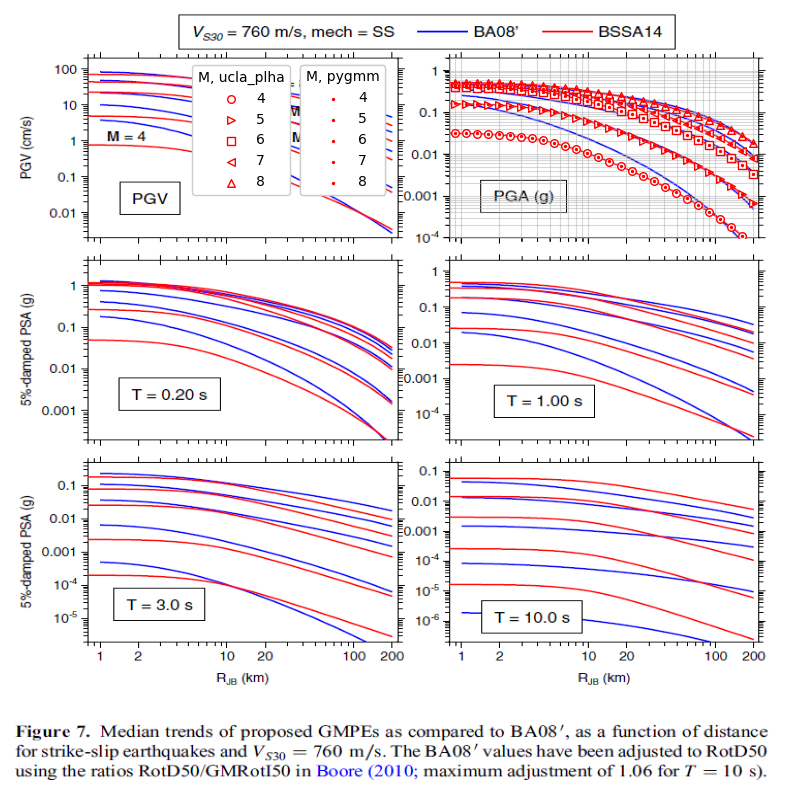

In [124]:
# Reproduce PGA part of Fig. 7 from BSSA14 model
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from ucla_plha.ground_motion_models import bssa14

rjb_vec = np.logspace(np.log(0.8), np.log10(200), 30)
m_vec = np.asarray([4, 5, 6, 7, 8])
rjb = np.empty(len(m_vec) * len(rjb_vec), dtype=float)
m = np.empty(len(m_vec) * len(rjb_vec), dtype=float)
vs30 = 760
fault_type = np.full(len(m), 3)
dip = np.full(len(m), 90)
I = 0
pga_pygmm = np.empty(len(m))
for i in range(len(m_vec)):
    for j in range(len(rjb_vec)):
        m[I] = m_vec[i]
        rjb[I] = rjb_vec[j]
        s = pygmm.model.Scenario(
            mag = m[I], 
            dist_jb = rjb[I], 
            dip = dip[I], 
            v_s30 = vs30, 
            mechanism = 'SS',
        )
        pygmm_output = pygmm.BooreStewartSeyhanAtkinson2014(s)
        pga_pygmm[I] = pygmm_output.spec_accels[0]
        I += 1



mu_ln, sigma_ln = bssa14.get_im(vs30, rjb, m, fault_type)
pga = np.exp(mu_ln)

fig, ax_img = plt.subplots(figsize=(10, 10))
image = mpimg.imread("bssa14_fig7.png")
ax_img.imshow(image, extent=[6,0,6,0])
ax_img.axis("off")

markers = ['o', '>', 's', '<', '^']

ax_data = fig.add_axes((0.566,0.6525,0.310,0.1795), frameon=False)
ucla_plha_scatter = []
pygmm_scatter = []
for i, m_val in enumerate(m_vec):
    temp = ax_data.scatter(
        rjb[m == m_val],
        pga[m == m_val],
        label=str(m_val),
        edgecolor='red',
        facecolor='white', 
        s=30, 
        marker=markers[i],
        zorder=2
    )
    ucla_plha_scatter.append(temp)
    temp = ax_data.scatter(
        rjb[m == m_val],
        pga_pygmm[m == m_val],
        label=str(m_val),
        color='red',
        s=2,
        zorder=3,
    )
    pygmm_scatter.append(temp)
ax_data.set_yscale("log")
ax_data.set_xscale("log")
ax_data.set_ylim(0.0001, 2)
ax_data.set_xlim(0.8, 220)
first_legend = ax_data.legend(handles = ucla_plha_scatter, title="M, ucla_plha", loc='upper left', bbox_to_anchor=(-0.85,1.0,0,0), framealpha=1.0)
second_legend = ax_data.legend(handles = pygmm_scatter, title="M, pygmm", loc='upper left', bbox_to_anchor=(-0.5,1.0,0,0), framealpha=1.0)
ax_data.add_artist(first_legend)
ax_data.add_artist(second_legend)
ax_data.grid(True, alpha=0.5, which="both")
ax_data.tick_params(axis='x', labelbottom=False)
ax_data.tick_params(axis='y', labelleft=False)

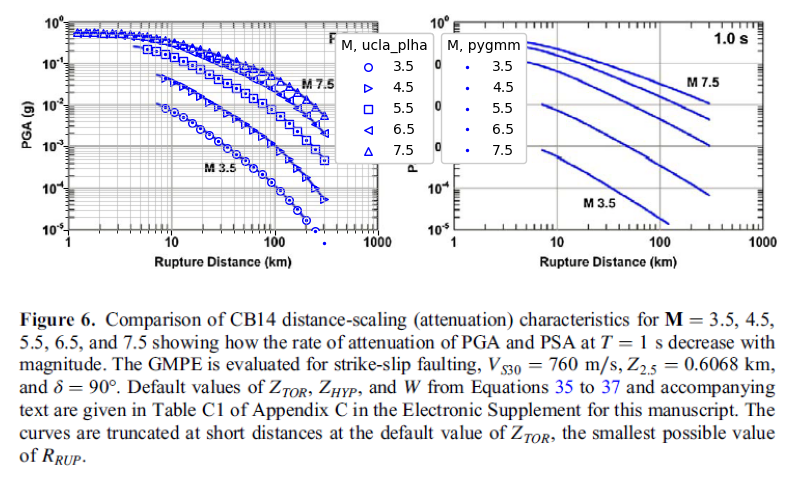

In [118]:
# Reproduce Fig. 6 from CB14 model
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from ucla_plha.ground_motion_models import cb14

rrup_vec = np.logspace(0, np.log10(300), 30)
m_vec = np.asarray([3.5, 4.5, 5.5, 6.5, 7.5])
rrup_lim = np.asarray([8, 8, 5, 1.0, 1.0])
ztor_vec = np.asarray([8, 8, 5, 0.0, 0.0])
colors = np.asarray(["blue", "cyan", "darkgreen", "lime", "red", "magenta"])
rrup = np.empty(len(m_vec) * len(rrup_vec), dtype=float)
rjb = np.empty(len(m_vec) * len(rrup_vec), dtype=float)
m = np.empty(len(m_vec) * len(rrup_vec), dtype=float)
ztor = np.empty(len(m_vec) * len(rrup_vec), dtype=float)
zhyp = np.empty(len(m_vec) * len(rrup_vec), dtype=float)
zbor = np.empty(len(m_vec) * len(rrup_vec), dtype=float)
I = 0
vs30 = 760
dip = np.full(len(m), 90.0)
rx = np.full(len(m), 0.0)
rx1 = np.full(len(m), 0.0)
fault_type = np.full(len(m), 3)
pga_pygmm = np.empty(len(m))
for i in range(len(m_vec)):
    for j in range(len(rrup_vec)):
        m[I] = m_vec[i]
        rrup[I] = rrup_vec[j]
        rjb[I] = rrup_vec[j]
        ztor[I] = np.max([2.673 - 1.136 * np.max([m[I] - 4.970, 0]), 0]) ** 2
        W = np.sqrt(10 ** ((m[I] - 4.07) / 0.98))
        zhyp[I] = ztor[I] - 0.5 * W * np.sin(dip[I] * np.pi / 180.0)
        zbor[I] = ztor[I] + W
        s = pygmm.model.Scenario(
            mag = m[I], 
            dist_jb = rjb[I],
            dist_rup = rrup[I],
            dist_x = rx[I],
            dip = dip[I], 
            v_s30 = vs30, 
            mechanism = 'SS',
        )
        pygmm_output = pygmm.CampbellBozorgnia2014(s)
        pga_pygmm[I] = pygmm_output.spec_accels[0]
        I += 1


mu_ln, sigma_ln = cb14.get_im(vs30, rjb, rrup, rx, rx1, m, fault_type, ztor, zbor, dip)
pga = np.exp(mu_ln)

fig, ax_img = plt.subplots(figsize=(10, 10))

image = mpimg.imread("cb14_fig6.png")
ax_img.imshow(image)
ax_img.axis("off")
markers = ['o', '>', 's', '<', '^']
ax_data = fig.add_axes((0.183,0.505,0.31,0.208), frameon=False)
ucla_plha_scatter = []
pygmm_scatter = []
for i, m_val in enumerate(m_vec):
    temp = ax_data.scatter(
        rrup[(m == m_val) & (rrup > rrup_lim[i])],
        pga[(m == m_val) & (rrup > rrup_lim[i])],
        label=str(m_val),
        facecolor = 'white',
        edgecolor = 'blue',
        marker = markers[i],
        s = 30
    )
    ucla_plha_scatter.append(temp)
    temp = ax_data.scatter(
        rrup[(m == m_val) & (rrup > rrup_lim[i])],
        pga_pygmm[(m == m_val) & (rrup > rrup_lim[i])],
        color= 'blue',
        label = str(m_val),
        s=2,
        clip_on = False,
    )
    pygmm_scatter.append(temp)
ax_data.set_yscale("log")
ax_data.set_xscale("log")
ax_data.set_ylim(0.00001, 1)
ax_data.set_xlim(1, 1000)
legend1 = ax_data.legend(title="M, ucla_plha", handles=ucla_plha_scatter, loc='upper right', bbox_to_anchor=(1.2,0.98,0,0), framealpha=1.0)
ax_data.add_artist(legend1)
legend2 = ax_data.legend(title="M, pygmm", handles=pygmm_scatter, loc='upper right', bbox_to_anchor=(1.5,0.98,0,0), framealpha=1.0)
ax_data.add_artist(legend1)
ax_data.grid(True, alpha=0.5, which="both")
# ax_data.set_xlabel("Rupture Distance (km)")
# ax_data.set_ylabel("PGA (g)")
ax_data.tick_params(axis='x', labelbottom=False)
ax_data.tick_params(axis='y', labelleft=False)

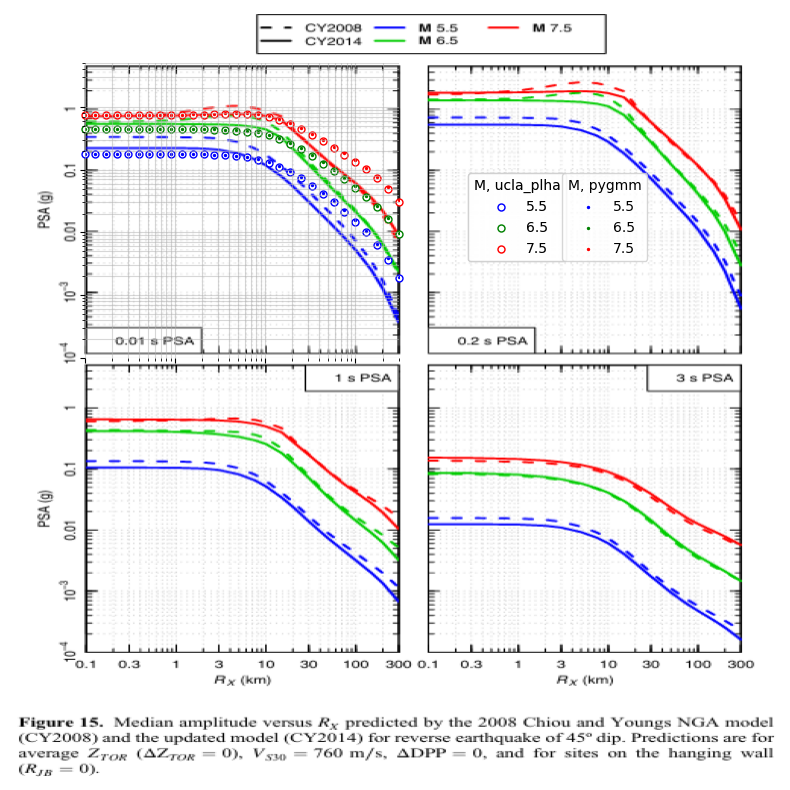

In [139]:
# Reproduce Fig. 6 from CB14 model
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from ucla_plha.ground_motion_models import cy14
import pygmm

rx_vec = np.logspace(-1, np.log10(300), 30)
m_vec = np.asarray([5.5, 6.5, 7.5])
rrup = np.empty(len(m_vec) * len(rx_vec), dtype=float)
rjb = np.empty(len(m_vec) * len(rx_vec), dtype=float)
rx = np.empty(len(m_vec) * len(rx_vec), dtype=float)
m = np.empty(len(m_vec) * len(rx_vec), dtype=float)
ztor = np.empty(len(m_vec) * len(rx_vec), dtype=float)
zhyp = np.empty(len(m_vec) * len(rx_vec), dtype=float)
zbor = np.empty(len(m_vec) * len(rx_vec), dtype=float)
I = 0
vs30 = 760
dip = np.full(len(m), 45.0)
fault_type = np.full(len(m), 1)
pga_pygmm = np.zeros(len(m))
for i in range(len(m_vec)):
    for j in range(len(rx_vec)):
        m[I] = m_vec[i]
        rx[I] = rx_vec[j]
        rjb[I] = 0.0
        ztor[I] = np.max([2.704 - 1.226 * np.max([m[I] - 5.849, 0]), 0]) ** 2
        if(rx[I] > ztor[I]):
            rrup[I] = (rx[I] + ztor[I]) / np.sqrt(2)
        else:
            rrup[I] = np.sqrt(rx[I] ** 2 + ztor[I] ** 2)
        s = pygmm.model.Scenario(
            mag = m[I], 
            dist_jb = rjb[I], 
            dist_x = rx[I], 
            dist_rup = rrup[I], 
            dip = dip[I], 
            v_s30 = vs30, 
            mechanism = 'RS',
            on_hanging_wall = True,
        )
        pygmm_output = pygmm.ChiouYoungs2014(s)
        pga_pygmm[I] = pygmm_output.spec_accels[0]
        I += 1

measured_vs30 = False
mu_ln, sigma_ln = cy14.get_im(
    vs30, rjb, rrup, rx, m, fault_type, measured_vs30, dip, ztor, z1p0=None
)
pga = np.exp(mu_ln)

fig, ax_img = plt.subplots(figsize=(10, 10))

image = mpimg.imread("cy14_validation_rv_fig15.png")
ax_img.imshow(image, extent=[6,0,6,0])
ax_img.axis("off")
colors = ['blue', 'green', 'red']
ax_data = fig.add_axes((0.202,0.532,0.314,0.295), frameon=False)
ucla_plha_scatter = []
pygmm_scatter = []
for i, m_val in enumerate(m_vec):
    temp = ax_data.scatter(
        rx[m == m_val],
        pga[m == m_val],
        label=str(m_val),
        edgecolor=colors[i],
        facecolor='white',
        s=25,
        clip_on = False
    )
    ucla_plha_scatter.append(temp)
    temp = ax_data.scatter(
        rx[m == m_val],
        pga_pygmm[m == m_val],
        label=str(m_val),
        color=colors[i],
        s=2,
    )
    pygmm_scatter.append(temp)
    
ax_data.set_yscale("log")
ax_data.set_xscale("log")
ax_data.set_ylim(0.0001, 5)
ax_data.set_xlim(0.1, 300)
legend1 = ax_data.legend(title="M, ucla_plha", handles=ucla_plha_scatter, loc='upper left', bbox_to_anchor=(1.2,0.65,0,0))
ax_data.add_artist(legend1)
legend2 = ax_data.legend(title="M, pygmm", handles=pygmm_scatter, loc='upper left', bbox_to_anchor=(1.5,0.65,0,0))
ax_data.add_artist(legend1)
ax_data.grid(True, alpha=0.5, which="both")
ax_data.tick_params(axis='x', labelbottom=False)
ax_data.tick_params(axis='y', labelleft=False)

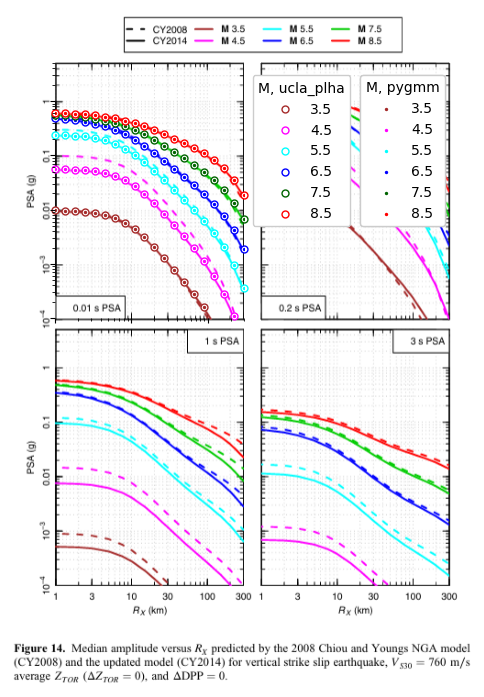

In [146]:
# Reproduce Fig. 6 from CB14 model
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from ucla_plha.ground_motion_models import cy14

rx_vec = np.logspace(0, np.log10(299), 20)
m_vec = np.asarray([3.5, 4.5, 5.5, 6.5, 7.5, 8.5])
colors = np.asarray(["brown", "magenta", "cyan", "blue", "darkgreen", "red"])
rrup = np.empty(len(m_vec) * len(rx_vec), dtype=float)
rjb = np.empty(len(m_vec) * len(rx_vec), dtype=float)
rx = np.empty(len(m_vec) * len(rx_vec), dtype=float)
m = np.empty(len(m_vec) * len(rx_vec), dtype=float)
ztor = np.empty(len(m_vec) * len(rx_vec), dtype=float)
zhyp = np.empty(len(m_vec) * len(rx_vec), dtype=float)
zbor = np.empty(len(m_vec) * len(rx_vec), dtype=float)
I = 0
vs30 = 760
dip = np.full(len(m), 90.0)
fault_type = np.full(len(m), 3)
pga_pygmm = np.zeros(len(m))
for i in range(len(m_vec)):
    for j in range(len(rx_vec)):
        m[I] = m_vec[i]
        rx[I] = rx_vec[j]
        rjb[I] = rx_vec[j]
        ztor[I] = np.max([2.673 - 1.136 * np.max([m[I] - 4.970, 0]), 0]) ** 2
        rrup[I] = np.sqrt(rx[I] ** 2 + ztor[I] ** 2)
        s = pygmm.model.Scenario(
            mag = m[I], dist_jb = rjb[I], dist_x = rx[I], dist_rup = rrup[I], dip = dip[I], v_s30 = vs30, mechanism='SS'
        )
        pygmm_output = pygmm.ChiouYoungs2014(s)
        pga_pygmm[I] = pygmm_output.spec_accels[0]
        I += 1

measured_vs30 = False
mu_ln, sigma_ln = cy14.get_im(
    vs30, rjb, rrup, rx, m, fault_type, measured_vs30, dip, ztor, z1p0=None
)
pga = np.exp(mu_ln)

fig, ax_img = plt.subplots(figsize=(6, 10))

image = mpimg.imread("cy14_validation_fig14.png")
ax_img.imshow(image)
ax_img.axis("off")
ax_data = fig.add_axes((0.2,0.525,0.315,0.255), frameon=False)
ucla_plha_scatter = []
pygmm_scatter = []
for i, m_val in enumerate(m_vec):
    temp = ax_data.scatter(
        rx[(m == m_val) & (pga > 1.e-4)],
        pga[(m == m_val) & (pga > 1.e-4)],
        label=str(m_val),
        edgecolor=colors[i],
        facecolor='white',
        s=25,
        clip_on = False
    )
    ucla_plha_scatter.append(temp)
    temp = ax_data.scatter(
        rx[(m == m_val) & (pga > 1.e-4)],
        pga_pygmm[(m == m_val) & (pga > 1.e-4)],
        label=str(m_val),
        color=colors[i],
        s=2,
    )
    pygmm_scatter.append(temp)
ax_data.set_yscale("log")
ax_data.set_xscale("log")
ax_data.set_ylim(0.0001, 5)
ax_data.set_xlim(1, 300)
legend1 = ax_data.legend(title="M, ucla_plha", handles=ucla_plha_scatter, loc='upper right', bbox_to_anchor=(1.6,0.98,0,0), alignment='center', framealpha=1.0)
ax_data.add_artist(legend1)
legend2 = ax_data.legend(title="M, pygmm", handles=pygmm_scatter, loc='upper right', bbox_to_anchor=(2.1,0.98,0,0), alignment='center', framealpha=1.0)
ax_data.add_artist(legend2)
ax_data.tick_params(axis='x', labelbottom=False)
ax_data.tick_params(axis='y', labelleft=False)